# Sequential Fine-tuning of AraBERT for Multi-task Classification

This notebook implements a sequential fine-tuning approach using AraBERT for multi-task classification on Arabic tweets. We'll address three classification tasks in sequence:

1. Sarcasm Detection
2. Sentiment Analysis
3. Dialect Identification

Instead of joint training, we'll follow a sequential learning approach where knowledge learned in earlier tasks is transferred to later tasks.

## Setup and Configuration

Let's start by installing the required packages and setting up our environment.

In [1]:
# Install required packages
!pip install transformers datasets sklearn pandas numpy matplotlib seaborn torch tqdm

  Preparing metadata (setup.py) ... error
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [15 lines of output]
      The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
      rather than 'sklearn' for pip commands.
      
      Here is how to fix this error in the main use cases:
      - use 'pip install scikit-learn' rather than 'pip install sklearn'
      - replace 'sklearn' by 'scikit-learn' in your pip requirements files
        (requirements.txt, setup.py, setup.cfg, Pipfile, etc ...)
      - if the 'sklearn' package is used by one of your dependencies,
        it would be great if you take some time to track which package uses
        'sklearn' instead of 'scikit-learn' and report it to their issue tracker
      - as a last resort, set the environment variable
        SKLEARN_ALLOW_DEPRECATED_SKLEARN_PACKAGE_INSTALL=True to avoid this error
      
      More information is available at
      https://g

In [24]:
# Import libraries
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    Trainer,
    TrainingArguments,
    get_linear_schedule_with_warmup
)
from torch.optim import AdamW
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import os
import random
import gc

## Hyperparameters and Configuration

All hyperparameters are centralized here for easy modification.

In [25]:
# General configuration
CONFIG = {
    # Model parameters
    "MODEL_NAME": "aubmindlab/bert-base-arabertv2",
    "MAX_LENGTH": 256,
    "BATCH_SIZE": 16,  # Adjust based on available memory
    "LEARNING_RATE": 2e-5,
    "NUM_EPOCHS": 5,   # Reduce to 3 for quick runs
    "WEIGHT_DECAY": 0.01,
    "DROPOUT": 0.3,    # Can be tuned between 0.1 and 0.3
    "GRAD_CLIP": 1.0,
    "EVAL_STRATEGY": "epoch",
    
    # Dataset paths
    "TRAIN_PATH": "training_data.csv",
    "TEST_PATH": "testing_data.csv",
    
    # Task configurations
    "TASKS": {
        "sarcasm": {
            "num_labels": 2,
            "id2label": {0: "Not Sarcastic", 1: "Sarcastic"},
            "label2id": {"False": 0, "True": 1},
            "model_save_path": "models/sarcasm_model"
        },
        "sentiment": {
            "num_labels": 3,
            "id2label": {0: "Negative", 1: "Neutral", 2: "Positive"},
            "label2id": {"NEG": 0, "NEU": 1, "POS": 2},
            "model_save_path": "models/sentiment_model"
        },
        "dialect": {
            "num_labels": 5,  # Adjust based on your actual data
            "id2label": {0: "msa", 1: "egypt", 2: "gulf", 3: "levant", 4: "magreb"},
            "label2id": {"msa": 0, "egypt": 1, "gulf": 2, "levant": 3, "magreb": 4},
            "model_save_path": "models/dialect_model"
        }
    },
    
    # Random seed for reproducibility
    "SEED": 42
}

# Create folders for model checkpoints
os.makedirs("models", exist_ok=True)

## Utility Functions

Let's define some utility functions for data loading, preprocessing, and evaluation.

In [26]:
# Set random seeds for reproducibility
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    
set_seed(CONFIG["SEED"])

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [27]:
def load_and_preprocess_data(task):
    """Load and preprocess the data for a specific task."""
    print(f"Loading data for {task} task...")
    
    # Load training and testing data
    train_df = pd.read_csv(CONFIG["TRAIN_PATH"])
    test_df = pd.read_csv(CONFIG["TEST_PATH"])
    
    train_df.dropna(inplace=True)
    test_df.dropna(inplace=True)

    # Convert labels to numeric format
    label_mapping = CONFIG["TASKS"][task]["label2id"]
    
    # Convert all labels to strings and then map
    train_df[task] = train_df[task].astype(str)
    test_df[task] = test_df[task].astype(str)
    
    train_df[f"{task}_label"] = train_df[task].map(label_mapping)
    test_df[f"{task}_label"] = test_df[task].map(label_mapping)
    
    print(f"Training data shape: {train_df.shape}")
    print(f"Testing data shape: {test_df.shape}")
    
    # Check for class imbalance
    print(f"\nClass distribution in training data:")
    print(train_df[task].value_counts())
    
    return train_df, test_df

In [28]:
def compute_weights(labels):
    """Compute class weights to handle imbalanced data."""
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(labels),
        y=labels
    )
    return dict(enumerate(class_weights))

In [29]:
class ArabicTweetDataset(Dataset):
    """Dataset class for Arabic tweets."""
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        
        # Remove batch dimension and move tensors to appropriate device
        encoding = {k: v.squeeze(0) for k, v in encoding.items()}
        encoding['labels'] = torch.tensor(label, dtype=torch.long)
        
        return encoding

In [30]:
def create_data_loaders(train_df, test_df, tokenizer, task, batch_size=16):
    """Create train and test data loaders for a specific task."""
    train_dataset = ArabicTweetDataset(
        texts=train_df['tweet'].tolist(),
        labels=train_df[f"{task}_label"].tolist(),
        tokenizer=tokenizer,
        max_length=CONFIG["MAX_LENGTH"]
    )
    
    test_dataset = ArabicTweetDataset(
        texts=test_df['tweet'].tolist(),
        labels=test_df[f"{task}_label"].tolist(),
        tokenizer=tokenizer,
        max_length=CONFIG["MAX_LENGTH"]
    )
    
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True
    )
    
    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False
    )
    
    return train_loader, test_loader, train_dataset, test_dataset

In [31]:
def load_model_for_task(task, previous_task=None):
    """Load a model for a specific task, optionally initializing from a previous task."""
    task_config = CONFIG["TASKS"][task]
    num_labels = task_config["num_labels"]
    id2label = task_config["id2label"]
    label2id = task_config["label2id"]
    
    # If there's a previous task, load from its checkpoint
    if previous_task and os.path.exists(CONFIG["TASKS"][previous_task]["model_save_path"]):
        print(f"Loading model from {previous_task} checkpoint...")
        # First load the base model without classifier head
        model = AutoModelForSequenceClassification.from_pretrained(
            CONFIG["MODEL_NAME"],
            num_labels=num_labels,
            id2label=id2label,
            label2id=label2id,
            hidden_dropout_prob=CONFIG["DROPOUT"],
            attention_probs_dropout_prob=CONFIG["DROPOUT"]
        )
        
        # Now load the pretrained weights but ignore the classifier
        base_model = AutoModelForSequenceClassification.from_pretrained(
            CONFIG["TASKS"][previous_task]["model_save_path"]
        )
        
        # Get the pretrained state dict
        pretrained_dict = base_model.state_dict()
        # Filter out classifier layers
        pretrained_dict = {k: v for k, v in pretrained_dict.items() if 'classifier' not in k}
        
        # Get the model's current state dict and update with pretrained weights
        model_dict = model.state_dict()
        model_dict.update(pretrained_dict)
        
        # Load the merged weights
        model.load_state_dict(model_dict)
        
        # Clean up to free memory
        del base_model, pretrained_dict, model_dict
        torch.cuda.empty_cache()
        gc.collect()
        
        print(f"Successfully loaded pretrained base model and initialized new classifier for {task}")
    else:
        print(f"Loading fresh model for {task}...")
        model = AutoModelForSequenceClassification.from_pretrained(
            CONFIG["MODEL_NAME"],
            num_labels=num_labels,
            id2label=id2label,
            label2id=label2id,
            hidden_dropout_prob=CONFIG["DROPOUT"],
            attention_probs_dropout_prob=CONFIG["DROPOUT"]
        )
    
    return model

In [32]:
def evaluate_model(model, data_loader, task):
    """Evaluate model performance on a given data loader."""
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Evaluating"):
            inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
            labels = batch['labels'].to(device)
            
            outputs = model(**inputs)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1).cpu().numpy()
            
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())
    
    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    if CONFIG["TASKS"][task]["num_labels"] > 2:
        f1 = f1_score(all_labels, all_preds, average='weighted')
    else:
        f1 = f1_score(all_labels, all_preds)
    
    # Print detailed classification report
    target_names = list(CONFIG["TASKS"][task]["id2label"].values())
    report = classification_report(all_labels, all_preds, target_names=target_names)
    
    # Create confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=target_names, 
                yticklabels=target_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix for {task}')
    plt.show()
    
    print(f"\nClassification Report for {task}:")
    print(report)
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")
    
    return {"accuracy": accuracy, "f1": f1}

In [33]:
def train_task(task, previous_task=None):
    """Train a model for a specific task, optionally using a model from a previous task."""
    print(f"\n{'='*50}\nTraining {task} classifier\n{'='*50}\n")
    
    # Load and preprocess data
    train_df, test_df = load_and_preprocess_data(task)
    
    # Load tokenizer
    tokenizer = AutoTokenizer.from_pretrained(CONFIG["MODEL_NAME"])
    
    # Create data loaders
    train_loader, test_loader, train_dataset, test_dataset = create_data_loaders(
        train_df, test_df, tokenizer, task, CONFIG["BATCH_SIZE"]
    )
    
    # Calculate class weights for imbalanced data
    # (Only for sarcasm and sentiment tasks)
    class_weights = None
    if task in ["sarcasm", "sentiment"]:
        class_weights = compute_weights(train_df[f"{task}_label"])
        print(f"Class weights: {class_weights}")
    
    # Load model
    model = load_model_for_task(task, previous_task)
    model.to(device)
    
    # Define optimizer and scheduler
    optimizer = AdamW(
        model.parameters(),
        lr=CONFIG["LEARNING_RATE"],
        weight_decay=CONFIG["WEIGHT_DECAY"]
    )
    
    total_steps = len(train_loader) * CONFIG["NUM_EPOCHS"]
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=int(0.1 * total_steps),
        num_training_steps=total_steps
    )
    
    # Training loop
    best_f1 = 0.0
    for epoch in range(CONFIG["NUM_EPOCHS"]):
        print(f"\nEpoch {epoch+1}/{CONFIG['NUM_EPOCHS']}")
        model.train()
        train_loss = 0.0
        
        progress_bar = tqdm(train_loader, desc=f"Training Epoch {epoch+1}")
        for batch in progress_bar:
            # Move batch to device
            batch = {k: v.to(device) for k, v in batch.items()}
            
            # Clear gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(**batch)
            loss = outputs.loss
            
            # Apply class weights if available
            if class_weights is not None:
                loss_weights = torch.tensor(
                    [class_weights[label.item()] for label in batch['labels']],
                    device=device
                )
                loss = (loss * loss_weights).mean()
            
            # Backward pass and update
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), CONFIG["GRAD_CLIP"])
            optimizer.step()
            scheduler.step()
            
            # Update progress bar
            train_loss += loss.item()
            progress_bar.set_postfix({"loss": f"{loss.item():.4f}"})
        
        avg_train_loss = train_loss / len(train_loader)
        print(f"Average training loss: {avg_train_loss:.4f}")
        
        # Evaluate on test set
        print("\nEvaluating on test set...")
        metrics = evaluate_model(model, test_loader, task)
        
        # Save the best model
        if metrics["f1"] > best_f1:
            best_f1 = metrics["f1"]
            print(f"New best F1 score: {best_f1:.4f}, saving model")
            model_save_path = CONFIG["TASKS"][task]["model_save_path"]
            model.save_pretrained(model_save_path)
            tokenizer.save_pretrained(model_save_path)
    
    print(f"\nTraining completed for {task} task")
    print(f"Best F1 score: {best_f1:.4f}")
    
    # Load the best model for final evaluation
    print("\nLoading best model for final evaluation...")
    model = AutoModelForSequenceClassification.from_pretrained(CONFIG["TASKS"][task]["model_save_path"])
    model.to(device)
    
    print("\nFinal evaluation on test set:")
    final_metrics = evaluate_model(model, test_loader, task)
    
    # Clean up to free memory
    del model, train_loader, test_loader, train_dataset, test_dataset
    torch.cuda.empty_cache()
    gc.collect()
    
    return final_metrics

## Sequential Learning Pipeline

Now we'll implement the sequential learning process. We'll train three models in sequence:
1. Sarcasm detection model
2. Sentiment analysis model (initialized from sarcasm model)
3. Dialect identification model (initialized from sentiment model)

In [34]:
def run_sequential_learning():
    """Run the sequential learning pipeline for all three tasks."""
    print("Starting sequential learning pipeline...\n")
    
    # Task 1: Sarcasm Detection
    sarcasm_metrics = train_task("sarcasm")
    
    # Task 2: Sentiment Analysis (initialized from sarcasm model)
    sentiment_metrics = train_task("sentiment", previous_task="sarcasm")
    
    # Task 3: Dialect Identification (initialized from sentiment model)
    dialect_metrics = train_task("dialect", previous_task="sentiment")
    
    # Summarize results
    print("\n" + "="*50)
    print("Sequential Learning Results Summary")
    print("="*50)
    print(f"Sarcasm Detection:    Accuracy = {sarcasm_metrics['accuracy']:.4f}, F1 = {sarcasm_metrics['f1']:.4f}")
    print(f"Sentiment Analysis:   Accuracy = {sentiment_metrics['accuracy']:.4f}, F1 = {sentiment_metrics['f1']:.4f}")
    print(f"Dialect Identification: Accuracy = {dialect_metrics['accuracy']:.4f}, F1 = {dialect_metrics['f1']:.4f}")
    
    return {
        "sarcasm": sarcasm_metrics,
        "sentiment": sentiment_metrics,
        "dialect": dialect_metrics
    }

Starting sequential learning pipeline...


Training sarcasm classifier

Loading data for sarcasm task...
Training data shape: (12546, 5)
Testing data shape: (2999, 5)

Class distribution in training data:
sarcasm
False    10379
True      2167
Name: count, dtype: int64
Class weights: {0: 0.604393486848444, 1: 2.894785417628057}
Loading fresh model for sarcasm...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at aubmindlab/bert-base-arabertv2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/5


Training Epoch 1:   0%|          | 0/785 [00:00<?, ?it/s]

Average training loss: 0.4538

Evaluating on test set...


Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

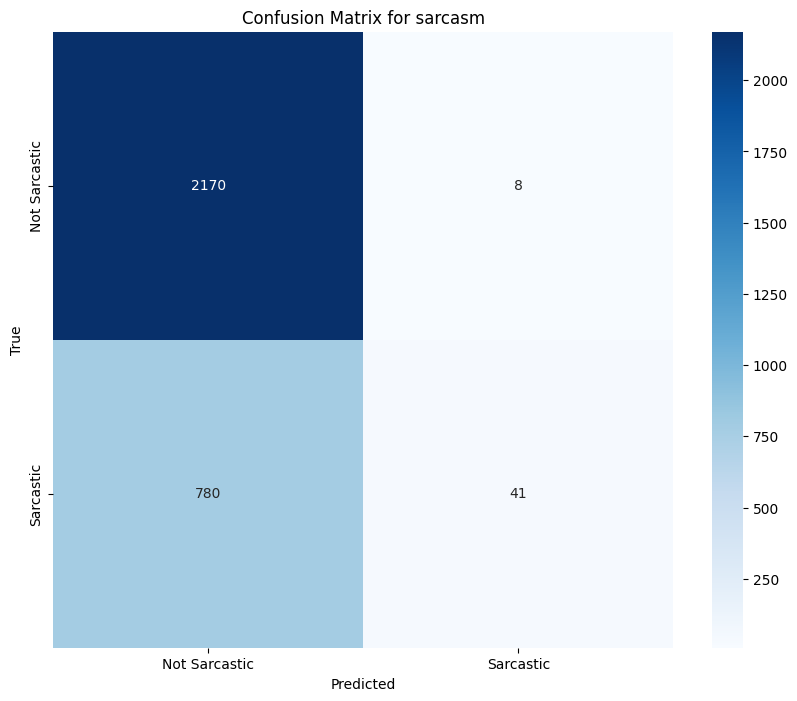


Classification Report for sarcasm:
               precision    recall  f1-score   support

Not Sarcastic       0.74      1.00      0.85      2178
    Sarcastic       0.84      0.05      0.09       821

     accuracy                           0.74      2999
    macro avg       0.79      0.52      0.47      2999
 weighted avg       0.76      0.74      0.64      2999

Accuracy: 0.7372
F1 Score: 0.0943
New best F1 score: 0.0943, saving model

Epoch 2/5


Training Epoch 2:   0%|          | 0/785 [00:00<?, ?it/s]

Average training loss: 0.3871

Evaluating on test set...


Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

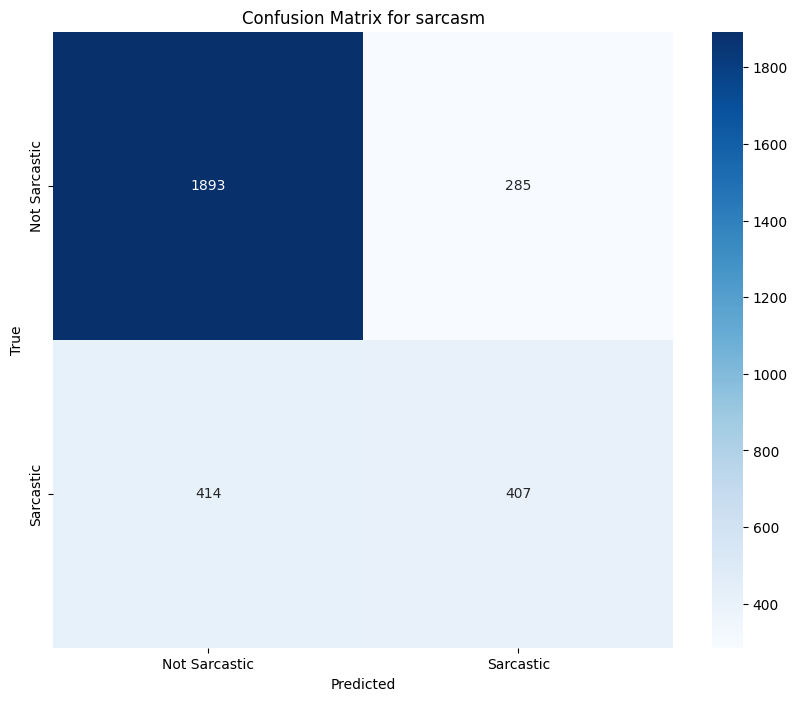


Classification Report for sarcasm:
               precision    recall  f1-score   support

Not Sarcastic       0.82      0.87      0.84      2178
    Sarcastic       0.59      0.50      0.54       821

     accuracy                           0.77      2999
    macro avg       0.70      0.68      0.69      2999
 weighted avg       0.76      0.77      0.76      2999

Accuracy: 0.7669
F1 Score: 0.5380
New best F1 score: 0.5380, saving model

Epoch 3/5


Training Epoch 3:   0%|          | 0/785 [00:00<?, ?it/s]

Average training loss: 0.3589

Evaluating on test set...


Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

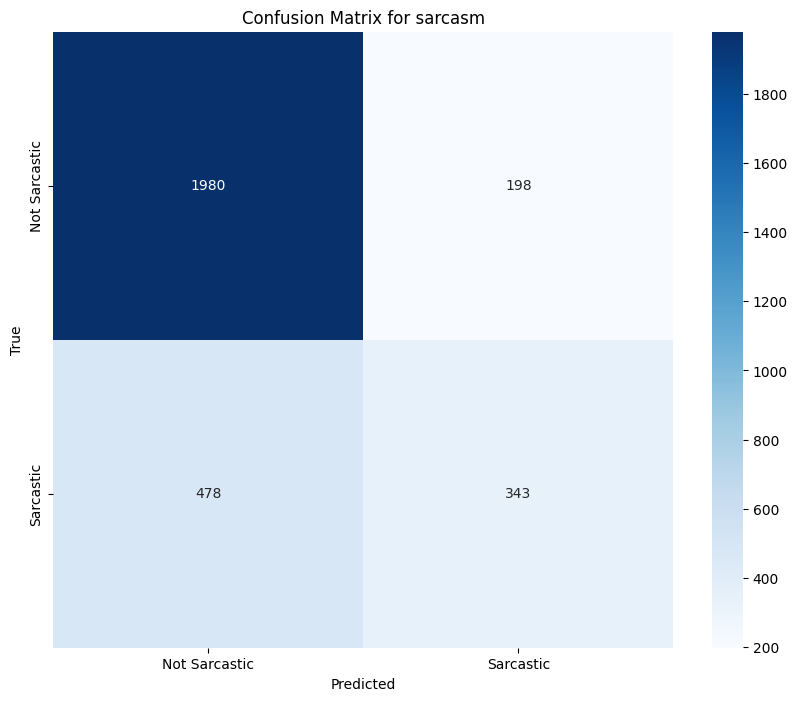


Classification Report for sarcasm:
               precision    recall  f1-score   support

Not Sarcastic       0.81      0.91      0.85      2178
    Sarcastic       0.63      0.42      0.50       821

     accuracy                           0.77      2999
    macro avg       0.72      0.66      0.68      2999
 weighted avg       0.76      0.77      0.76      2999

Accuracy: 0.7746
F1 Score: 0.5037

Epoch 4/5


Training Epoch 4:   0%|          | 0/785 [00:00<?, ?it/s]

Average training loss: 0.3228

Evaluating on test set...


Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

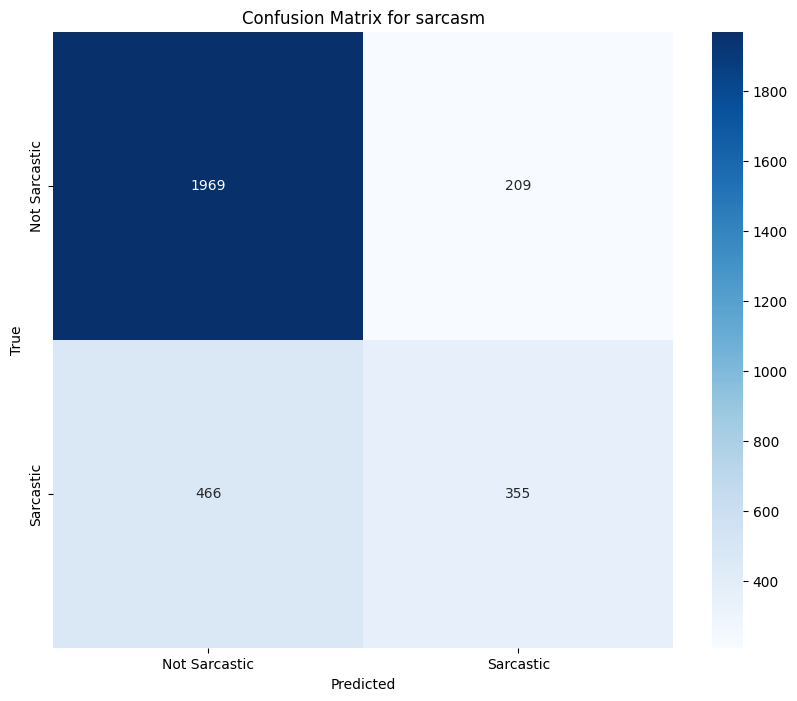


Classification Report for sarcasm:
               precision    recall  f1-score   support

Not Sarcastic       0.81      0.90      0.85      2178
    Sarcastic       0.63      0.43      0.51       821

     accuracy                           0.77      2999
    macro avg       0.72      0.67      0.68      2999
 weighted avg       0.76      0.77      0.76      2999

Accuracy: 0.7749
F1 Score: 0.5126

Epoch 5/5


Training Epoch 5:   0%|          | 0/785 [00:00<?, ?it/s]

Average training loss: 0.2996

Evaluating on test set...


Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

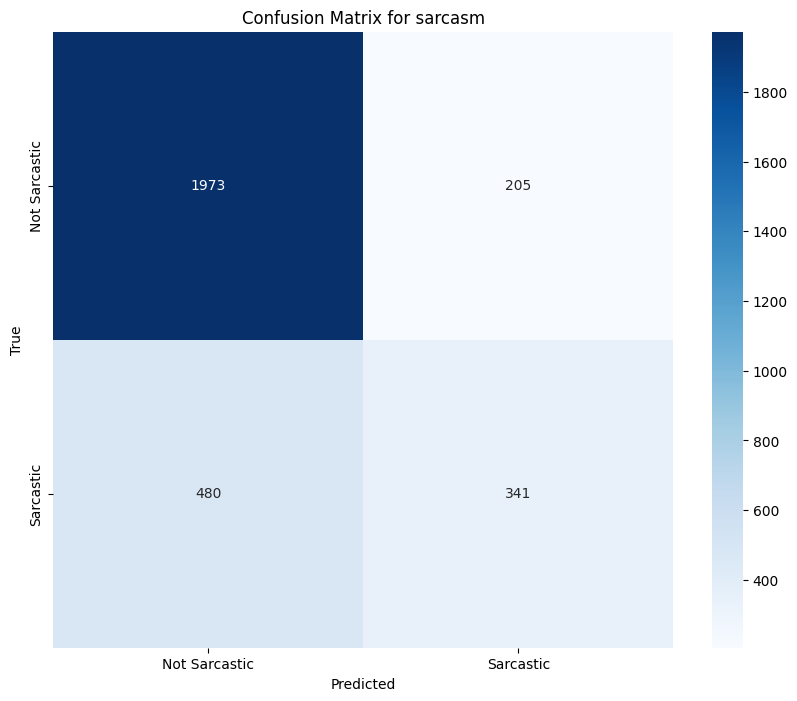


Classification Report for sarcasm:
               precision    recall  f1-score   support

Not Sarcastic       0.80      0.91      0.85      2178
    Sarcastic       0.62      0.42      0.50       821

     accuracy                           0.77      2999
    macro avg       0.71      0.66      0.68      2999
 weighted avg       0.76      0.77      0.76      2999

Accuracy: 0.7716
F1 Score: 0.4989

Training completed for sarcasm task
Best F1 score: 0.5380

Loading best model for final evaluation...

Final evaluation on test set:


Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

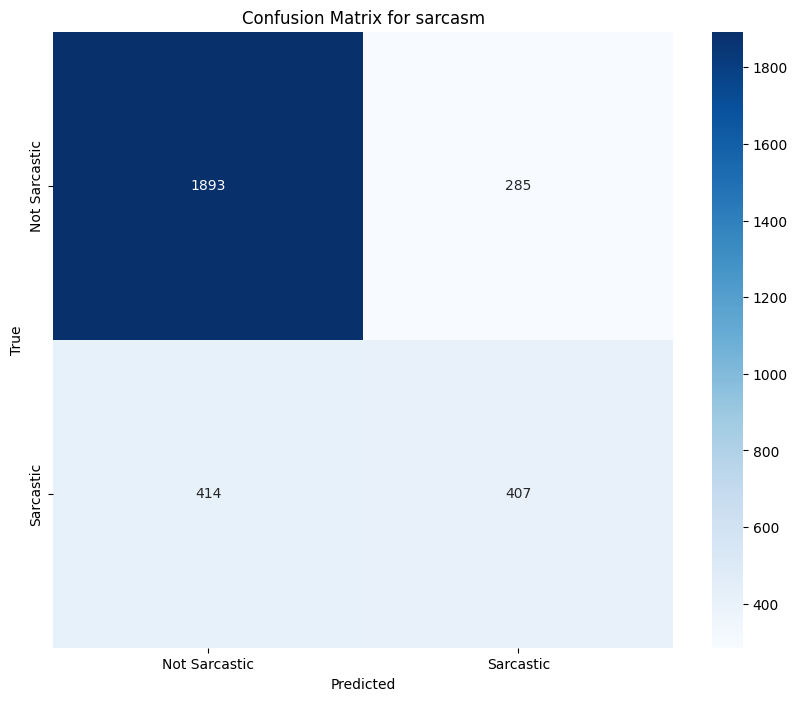


Classification Report for sarcasm:
               precision    recall  f1-score   support

Not Sarcastic       0.82      0.87      0.84      2178
    Sarcastic       0.59      0.50      0.54       821

     accuracy                           0.77      2999
    macro avg       0.70      0.68      0.69      2999
 weighted avg       0.76      0.77      0.76      2999

Accuracy: 0.7669
F1 Score: 0.5380

Training sentiment classifier

Loading data for sentiment task...
Training data shape: (12546, 5)
Testing data shape: (2999, 5)

Class distribution in training data:
sentiment
NEU    5746
NEG    4620
POS    2180
Name: count, dtype: int64
Class weights: {0: 0.9051948051948052, 1: 0.727810650887574, 2: 1.918348623853211}
Loading model from sarcasm checkpoint...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at aubmindlab/bert-base-arabertv2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Successfully loaded pretrained base model and initialized new classifier for sentiment

Epoch 1/5


Training Epoch 1:   0%|          | 0/785 [00:00<?, ?it/s]

Average training loss: 0.8315

Evaluating on test set...


Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

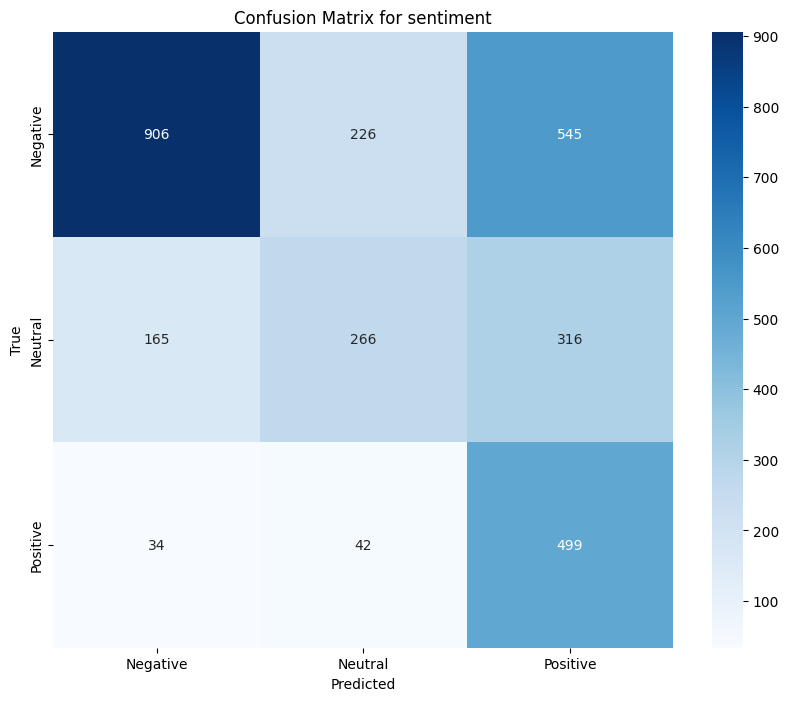


Classification Report for sentiment:
              precision    recall  f1-score   support

    Negative       0.82      0.54      0.65      1677
     Neutral       0.50      0.36      0.42       747
    Positive       0.37      0.87      0.52       575

    accuracy                           0.56      2999
   macro avg       0.56      0.59      0.53      2999
weighted avg       0.65      0.56      0.57      2999

Accuracy: 0.5572
F1 Score: 0.5665
New best F1 score: 0.5665, saving model

Epoch 2/5


Training Epoch 2:   0%|          | 0/785 [00:00<?, ?it/s]

Average training loss: 0.7087

Evaluating on test set...


Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

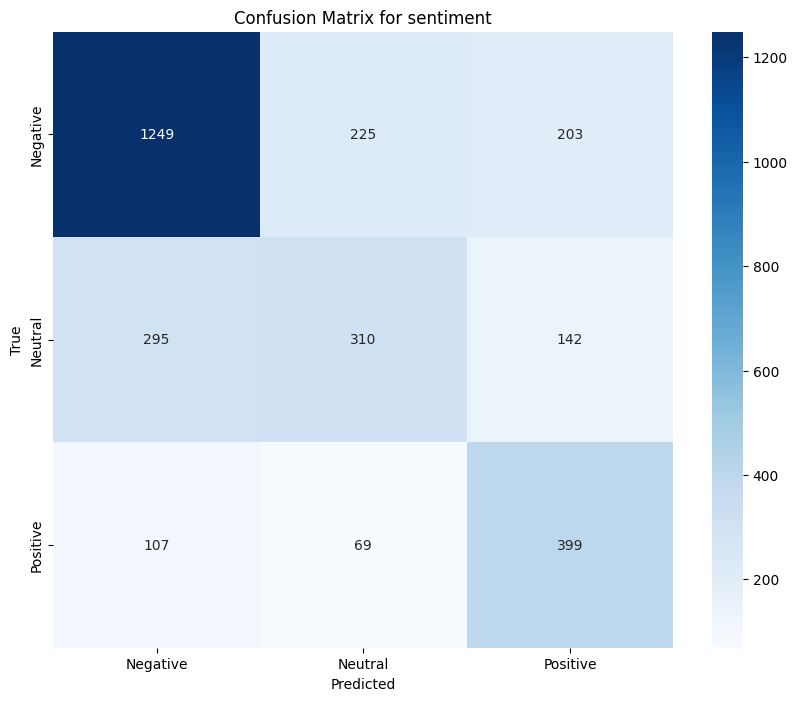


Classification Report for sentiment:
              precision    recall  f1-score   support

    Negative       0.76      0.74      0.75      1677
     Neutral       0.51      0.41      0.46       747
    Positive       0.54      0.69      0.61       575

    accuracy                           0.65      2999
   macro avg       0.60      0.62      0.60      2999
weighted avg       0.65      0.65      0.65      2999

Accuracy: 0.6529
F1 Score: 0.6500
New best F1 score: 0.6500, saving model

Epoch 3/5


Training Epoch 3:   0%|          | 0/785 [00:00<?, ?it/s]

Average training loss: 0.6446

Evaluating on test set...


Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

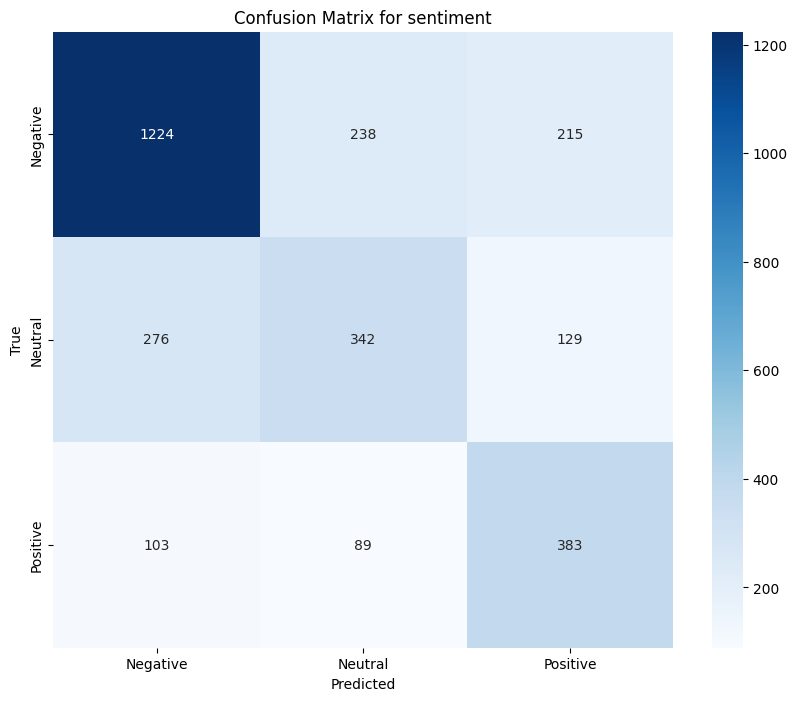


Classification Report for sentiment:
              precision    recall  f1-score   support

    Negative       0.76      0.73      0.75      1677
     Neutral       0.51      0.46      0.48       747
    Positive       0.53      0.67      0.59       575

    accuracy                           0.65      2999
   macro avg       0.60      0.62      0.61      2999
weighted avg       0.66      0.65      0.65      2999

Accuracy: 0.6499
F1 Score: 0.6505
New best F1 score: 0.6505, saving model

Epoch 4/5


Training Epoch 4:   0%|          | 0/785 [00:00<?, ?it/s]

Average training loss: 0.6002

Evaluating on test set...


Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

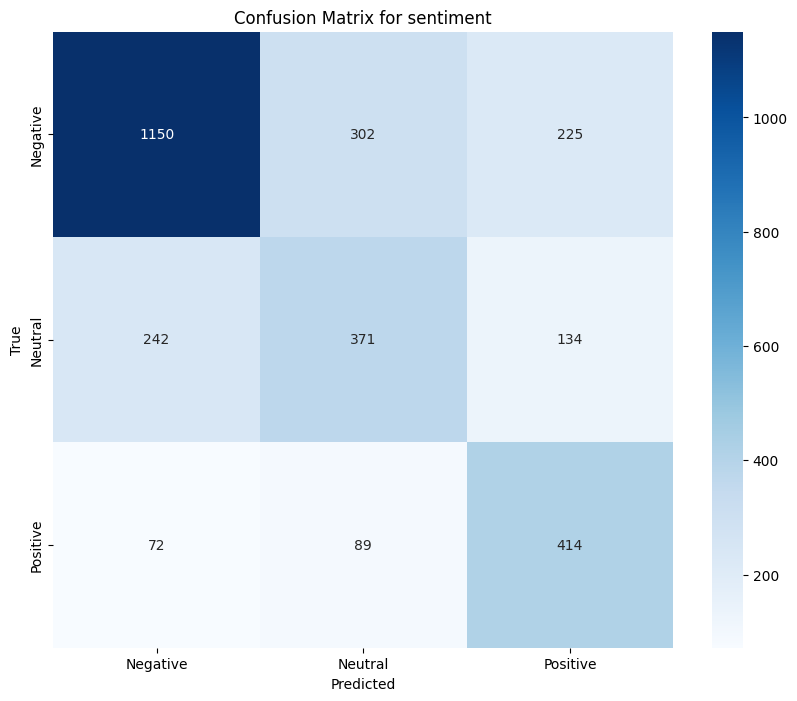


Classification Report for sentiment:
              precision    recall  f1-score   support

    Negative       0.79      0.69      0.73      1677
     Neutral       0.49      0.50      0.49       747
    Positive       0.54      0.72      0.61       575

    accuracy                           0.65      2999
   macro avg       0.60      0.63      0.61      2999
weighted avg       0.66      0.65      0.65      2999

Accuracy: 0.6452
F1 Score: 0.6497

Epoch 5/5


Training Epoch 5:   0%|          | 0/785 [00:00<?, ?it/s]

Average training loss: 0.5751

Evaluating on test set...


Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

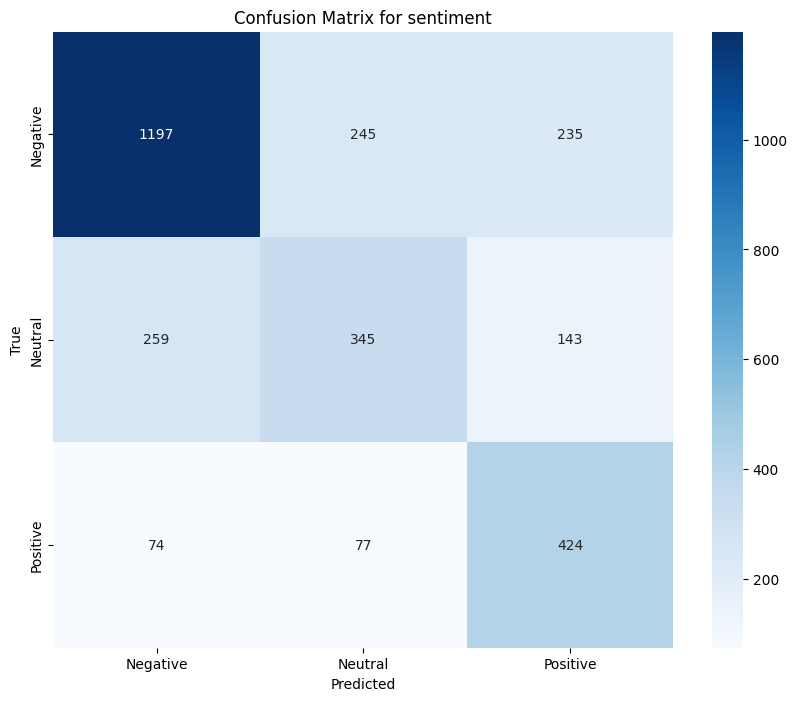


Classification Report for sentiment:
              precision    recall  f1-score   support

    Negative       0.78      0.71      0.75      1677
     Neutral       0.52      0.46      0.49       747
    Positive       0.53      0.74      0.62       575

    accuracy                           0.66      2999
   macro avg       0.61      0.64      0.62      2999
weighted avg       0.67      0.66      0.66      2999

Accuracy: 0.6556
F1 Score: 0.6570
New best F1 score: 0.6570, saving model

Training completed for sentiment task
Best F1 score: 0.6570

Loading best model for final evaluation...

Final evaluation on test set:


Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

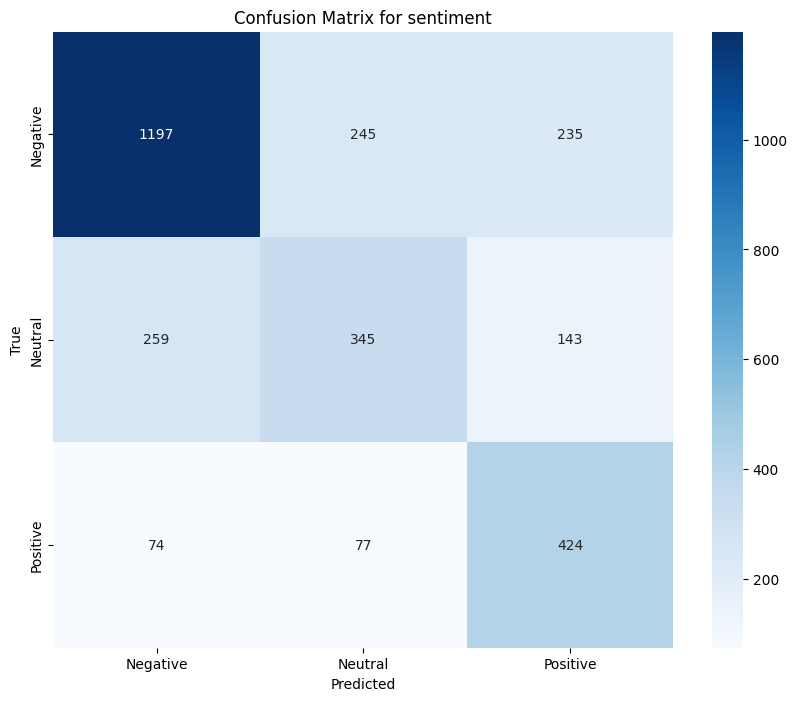


Classification Report for sentiment:
              precision    recall  f1-score   support

    Negative       0.78      0.71      0.75      1677
     Neutral       0.52      0.46      0.49       747
    Positive       0.53      0.74      0.62       575

    accuracy                           0.66      2999
   macro avg       0.61      0.64      0.62      2999
weighted avg       0.67      0.66      0.66      2999

Accuracy: 0.6556
F1 Score: 0.6570

Training dialect classifier

Loading data for dialect task...
Training data shape: (12546, 5)
Testing data shape: (2999, 5)

Class distribution in training data:
dialect
msa       8560
egypt     2675
gulf       644
levant     624
magreb      43
Name: count, dtype: int64
Loading model from sentiment checkpoint...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at aubmindlab/bert-base-arabertv2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Successfully loaded pretrained base model and initialized new classifier for dialect

Epoch 1/5


Training Epoch 1:   0%|          | 0/785 [00:00<?, ?it/s]

Average training loss: 0.8513

Evaluating on test set...


Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

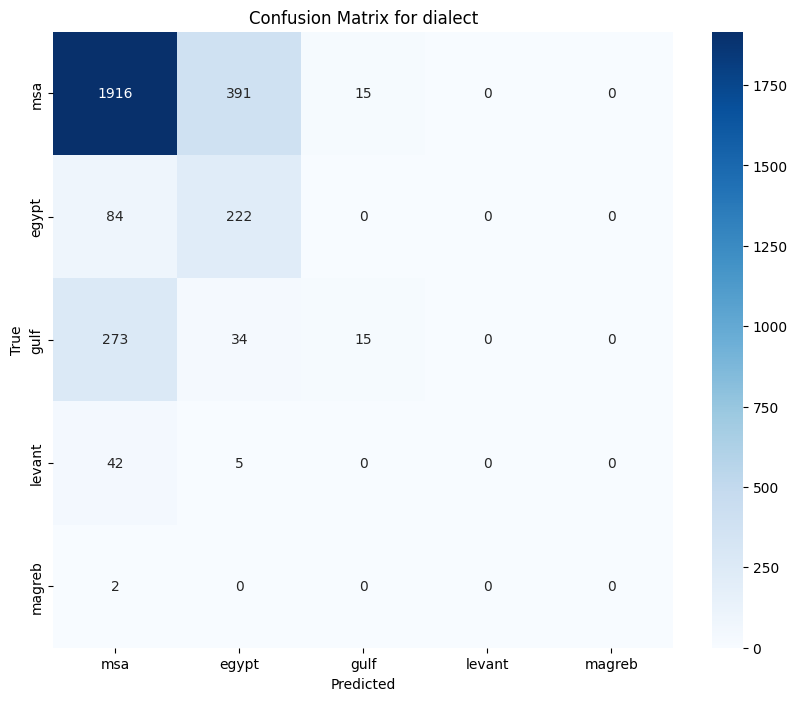


Classification Report for dialect:
              precision    recall  f1-score   support

         msa       0.83      0.83      0.83      2322
       egypt       0.34      0.73      0.46       306
        gulf       0.50      0.05      0.09       322
      levant       0.00      0.00      0.00        47
      magreb       0.00      0.00      0.00         2

    accuracy                           0.72      2999
   macro avg       0.33      0.32      0.27      2999
weighted avg       0.73      0.72      0.70      2999

Accuracy: 0.7179
F1 Score: 0.6960
New best F1 score: 0.6960, saving model

Epoch 2/5


Training Epoch 2:   0%|          | 0/785 [00:00<?, ?it/s]

Average training loss: 0.6773

Evaluating on test set...


Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

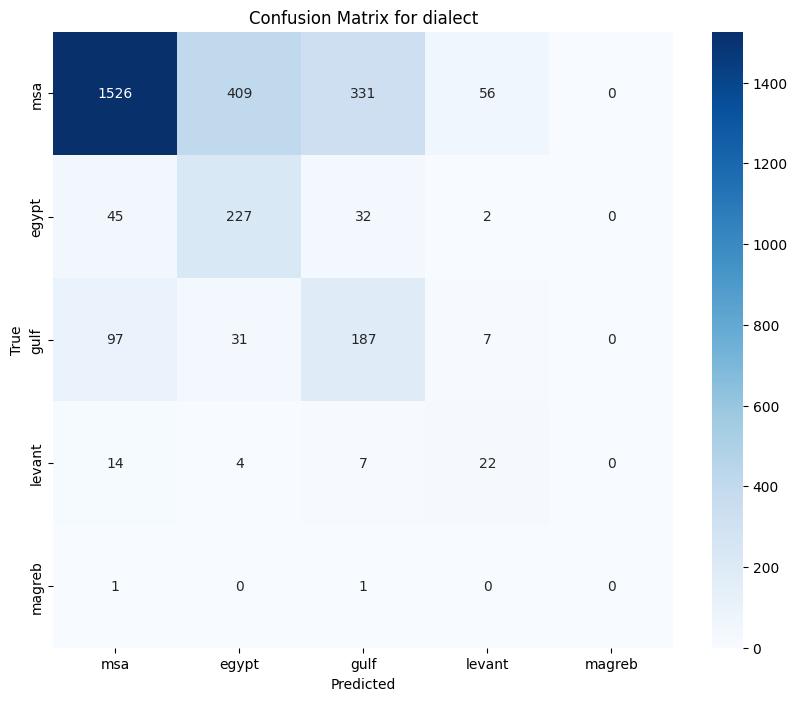


Classification Report for dialect:
              precision    recall  f1-score   support

         msa       0.91      0.66      0.76      2322
       egypt       0.34      0.74      0.46       306
        gulf       0.34      0.58      0.43       322
      levant       0.25      0.47      0.33        47
      magreb       0.00      0.00      0.00         2

    accuracy                           0.65      2999
   macro avg       0.37      0.49      0.40      2999
weighted avg       0.78      0.65      0.69      2999

Accuracy: 0.6542
F1 Score: 0.6882

Epoch 3/5


Training Epoch 3:   0%|          | 0/785 [00:00<?, ?it/s]

Average training loss: 0.6329

Evaluating on test set...


Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

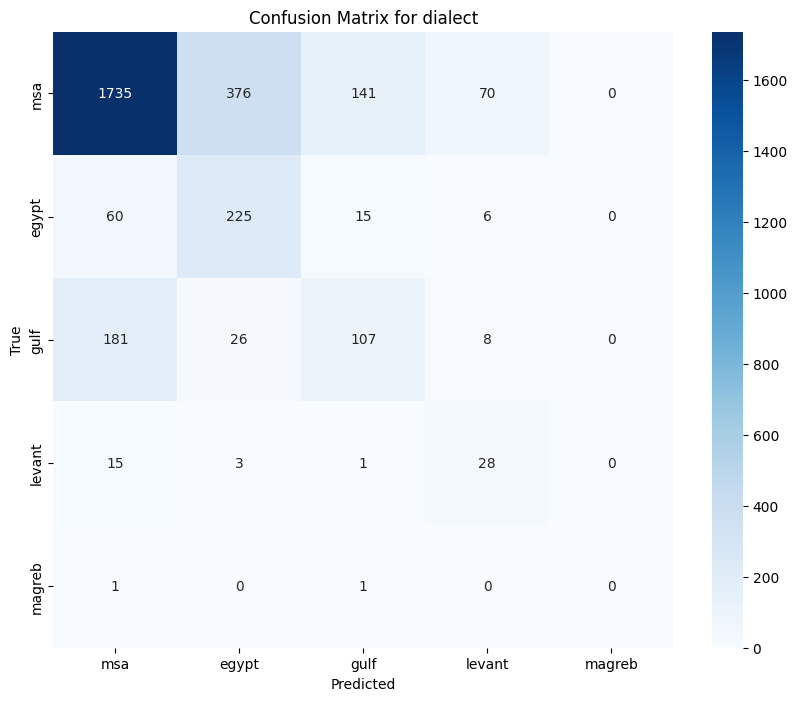


Classification Report for dialect:
              precision    recall  f1-score   support

         msa       0.87      0.75      0.80      2322
       egypt       0.36      0.74      0.48       306
        gulf       0.40      0.33      0.36       322
      levant       0.25      0.60      0.35        47
      magreb       0.00      0.00      0.00         2

    accuracy                           0.70      2999
   macro avg       0.38      0.48      0.40      2999
weighted avg       0.76      0.70      0.72      2999

Accuracy: 0.6986
F1 Score: 0.7165
New best F1 score: 0.7165, saving model

Epoch 4/5


Training Epoch 4:   0%|          | 0/785 [00:00<?, ?it/s]

Average training loss: 0.6029

Evaluating on test set...


Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

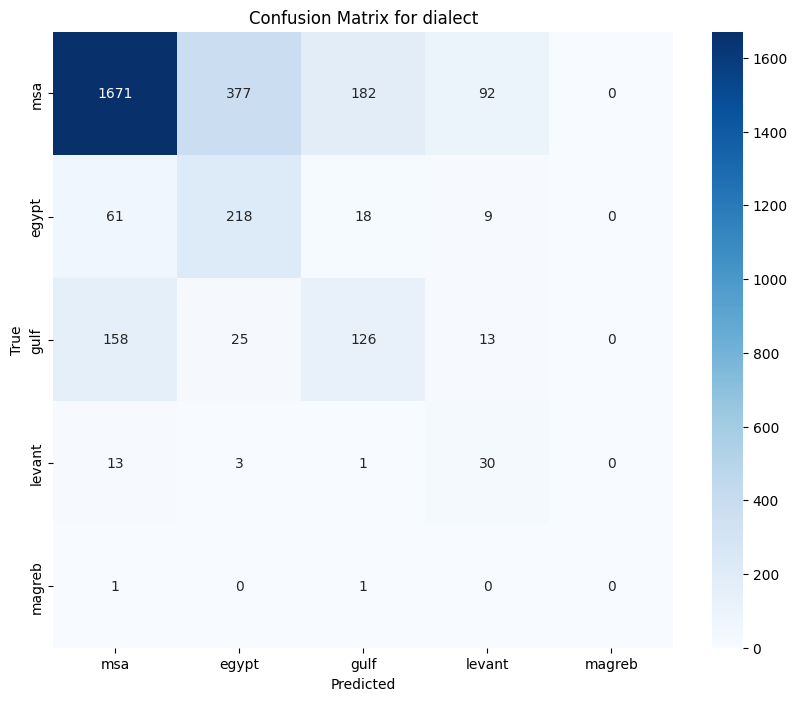


Classification Report for dialect:
              precision    recall  f1-score   support

         msa       0.88      0.72      0.79      2322
       egypt       0.35      0.71      0.47       306
        gulf       0.38      0.39      0.39       322
      levant       0.21      0.64      0.31        47
      magreb       0.00      0.00      0.00         2

    accuracy                           0.68      2999
   macro avg       0.36      0.49      0.39      2999
weighted avg       0.76      0.68      0.71      2999

Accuracy: 0.6819
F1 Score: 0.7067

Epoch 5/5


Training Epoch 5:   0%|          | 0/785 [00:00<?, ?it/s]

Average training loss: 0.5782

Evaluating on test set...


Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

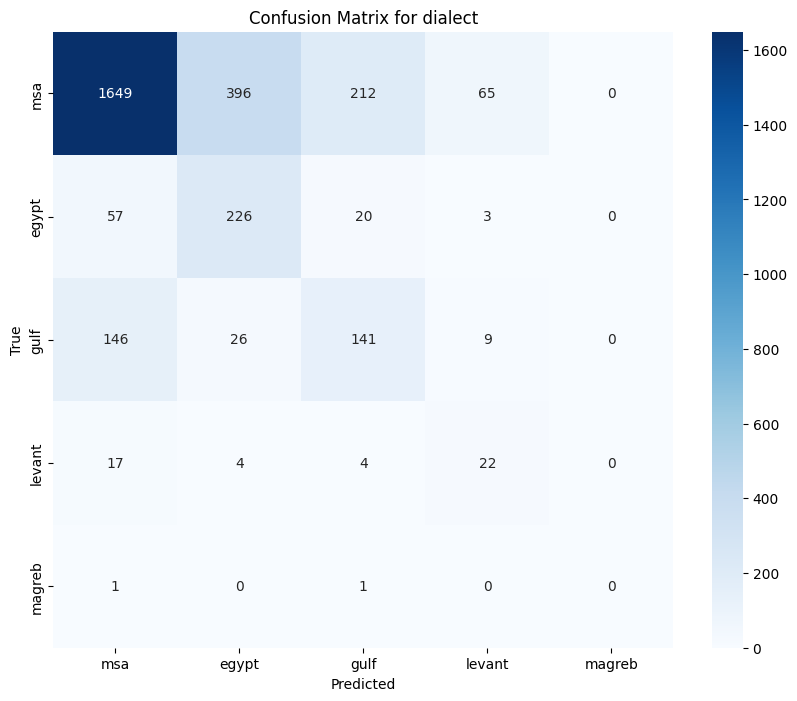


Classification Report for dialect:
              precision    recall  f1-score   support

         msa       0.88      0.71      0.79      2322
       egypt       0.35      0.74      0.47       306
        gulf       0.37      0.44      0.40       322
      levant       0.22      0.47      0.30        47
      magreb       0.00      0.00      0.00         2

    accuracy                           0.68      2999
   macro avg       0.36      0.47      0.39      2999
weighted avg       0.76      0.68      0.71      2999

Accuracy: 0.6796
F1 Score: 0.7053

Training completed for dialect task
Best F1 score: 0.7165

Loading best model for final evaluation...

Final evaluation on test set:


Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

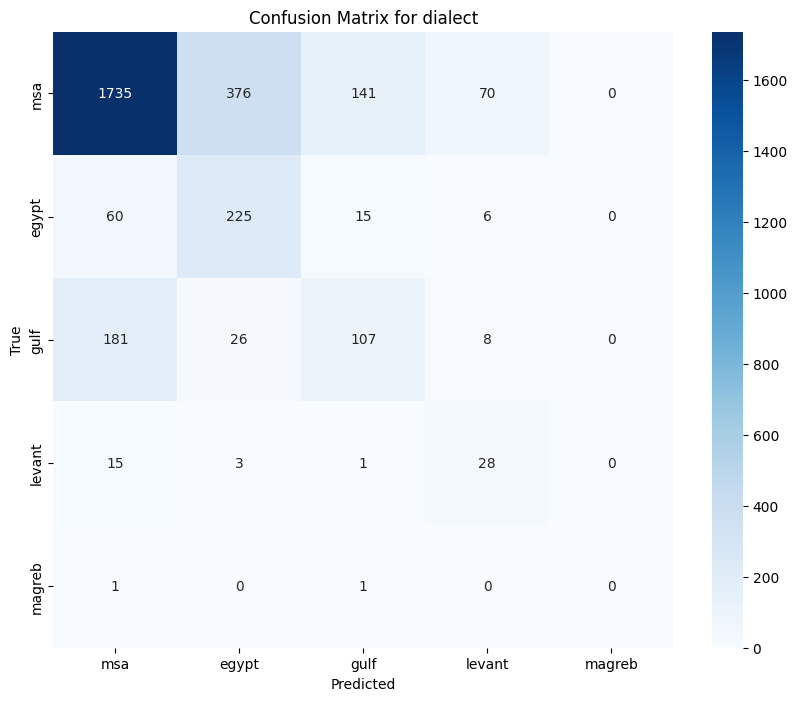


Classification Report for dialect:
              precision    recall  f1-score   support

         msa       0.87      0.75      0.80      2322
       egypt       0.36      0.74      0.48       306
        gulf       0.40      0.33      0.36       322
      levant       0.25      0.60      0.35        47
      magreb       0.00      0.00      0.00         2

    accuracy                           0.70      2999
   macro avg       0.38      0.48      0.40      2999
weighted avg       0.76      0.70      0.72      2999

Accuracy: 0.6986
F1 Score: 0.7165

Sequential Learning Results Summary
Sarcasm Detection:    Accuracy = 0.7669, F1 = 0.5380
Sentiment Analysis:   Accuracy = 0.6556, F1 = 0.6570
Dialect Identification: Accuracy = 0.6986, F1 = 0.7165


In [35]:
# Run the sequential learning pipeline
results = run_sequential_learning()

## Inference with the Trained Models

Let's create a function to perform inference with our trained models.

In [36]:
def predict_single_text(text, task):
    """Make a prediction for a single text using a trained model."""
    model_path = CONFIG["TASKS"][task]["model_save_path"]
    
    # Load model and tokenizer
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    model = AutoModelForSequenceClassification.from_pretrained(model_path)
    model.to(device)
    model.eval()
    
    # Tokenize input
    inputs = tokenizer(
        text,
        truncation=True,
        padding=True,
        max_length=CONFIG["MAX_LENGTH"],
        return_tensors="pt"
    )
    
    # Move inputs to device
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    # Make prediction
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        probs = torch.nn.functional.softmax(logits, dim=1)
        pred_class = torch.argmax(probs, dim=1).item()
    
    # Convert to label
    pred_label = CONFIG["TASKS"][task]["id2label"][pred_class]
    
    # Get probabilities for all classes
    probs_dict = {CONFIG["TASKS"][task]["id2label"][i]: prob.item() 
                 for i, prob in enumerate(probs[0])}
    
    return {
        "prediction": pred_label,
        "probabilities": probs_dict
    }

In [37]:
def predict_all_tasks(text):
    """Make predictions for all three tasks for a given text."""
    results = {}
    
    for task in ["sarcasm", "sentiment", "dialect"]:
        print(f"Predicting {task}...")
        task_result = predict_single_text(text, task)
        results[task] = task_result
    
    return results

In [45]:
# Example usage
sample_text = "الجو جميل جداً اليوم"
predictions = predict_all_tasks(sample_text)
print(f"First sen 1:")
print(f"Sarcasm: {predictions['sarcasm']['prediction']}")
print(f"Sentiment: {predictions['sentiment']['prediction']}")
print(f"Dialect: {predictions['dialect']['prediction']}")

sample_text2 = "اخوي حانق يالغلا وشفيك معصب؟ عادي تراهم بشر يفطرون الصبح قلابة وتميس تيك ات ايزي مان"
predictions = predict_all_tasks(sample_text2)
print(f"Second sen 2:")
print(f"Sarcasm: {predictions['sarcasm']['prediction']}")
print(f"Sentiment: {predictions['sentiment']['prediction']}")
print(f"Dialect: {predictions['dialect']['prediction']}")

sample_text3 = "اتجوز عروسة اتجوزت سجادة فيه ايه يابشر"
predictions = predict_all_tasks(sample_text3)
print(f"Third sen 3:")
print(f"Sarcasm: {predictions['sarcasm']['prediction']}")
print(f"Sentiment: {predictions['sentiment']['prediction']}")
print(f"Dialect: {predictions['dialect']['prediction']}")


Predicting sarcasm...
Predicting sentiment...
Predicting dialect...
First sen 1:
Sarcasm: Not Sarcastic
Sentiment: Positive
Dialect: msa
Predicting sarcasm...
Predicting sentiment...
Predicting dialect...
Second sen 2:
Sarcasm: Sarcastic
Sentiment: Negative
Dialect: gulf
Predicting sarcasm...
Predicting sentiment...
Predicting dialect...
Third sen 3:
Sarcasm: Sarcastic
Sentiment: Negative
Dialect: egypt


## Analysis of Sequential Learning Benefits

Let's compare the performance of our sequential learning approach with single-task learning.

In [39]:
def train_single_task(task):
    """Train a model for a single task without leveraging previous knowledge."""
    print(f"\n{'='*50}\nTraining {task} classifier (Single Task)\n{'='*50}\n")
    
    # Same as train_task but without previous_task
    single_metrics = train_task(task)
    return single_metrics

In [ ]:
# Optional: Compare with single-task learning for sentiment
# Uncomment to run this comparison

# CONFIG["TASKS"]["sentiment"]["model_save_path"] = "models/sentiment_single_task"
# single_sentiment_metrics = train_single_task("sentiment")

# print("\nComparison:")
# print(f"Sequential Learning - Sentiment: Accuracy = {results['sentiment']['accuracy']:.4f}, F1 = {results['sentiment']['f1']:.4f}")
# print(f"Single Task - Sentiment: Accuracy = {single_sentiment_metrics['accuracy']:.4f}, F1 = {single_sentiment_metrics['f1']:.4f}")

## Conclusion

In this notebook, we've implemented a sequential learning approach for fine-tuning AraBERT on three Arabic text classification tasks:

1. Sarcasm detection
2. Sentiment analysis
3. Dialect identification

The sequential approach allows each task to benefit from the knowledge learned in previous tasks. This is particularly valuable when the tasks are related, as is the case with our tasks where understanding sarcasm can help with sentiment analysis, and both can inform dialect identification.

Key points of our implementation:

- We used AraBERT (aubmindlab/bert-base-arabertv2) as our base model
- We applied class weights to handle imbalanced data in sarcasm and sentiment tasks
- We saved model checkpoints between stages to enable continued learning
- We evaluated performance with accuracy, F1 score, and confusion matrices
- We created an inference pipeline to make predictions on new text

Future work could include:
- Experimenting with different model architectures
- Trying different sequential orders of tasks
- Implementing multi-task learning for comparison
- Adding data augmentation to address class imbalance
- Exploring ensemble methods to combine task-specific models